In [1]:
from pcdet.models.dense_heads.target_assigner.anchor_generator import AnchorGeneratorRV as AnchorGenerator


In [2]:
# from easydict import EasyDict
# config = [
#         EasyDict({
#             # 'anchor_sizes': [[2.1, 4.7, 1.7], [0.86, 0.91, 1.73], [0.84, 1.78, 1.78]],

#             # 'anchor_heights': [0, 0.5],
#             'class_name': 'Car',
#             'anchor_sizes': [[3.9, 1.6, 1.56]],
#             'anchor_rotations': [0, 1.57],
#             'anchor_bottom_heights': [-1.78],
#             'align_center': True,
#             'feature_map_stride': 8,
#             'matched_threshold': 0.6,
#             'unmatched_threshold': 0.4,
#         })
#     ]


from pcdet.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file


cfg_from_yaml_file("cfgs/kitti_models/sphoxelnet.yaml", cfg)

A = AnchorGenerator(
                   anchor_range=[6,-40,-3,70.4,40,1],
    anchor_generator_config= cfg.MODEL.DENSE_HEAD.ANCHOR_GENERATOR_CONFIG)

anchors, num_anchors_per_location = A.generate_anchors([[64,64],[64,64],[64,64]])

In [3]:
anchors[0].shape

torch.Size([1, 64, 64, 1, 2, 7])

In [4]:
from visual_utils.vis import kitti_vis
import numpy as np

In [5]:
anchors[0].shape

torch.Size([1, 64, 64, 1, 2, 7])

In [6]:
anchors[0][0][32][8][0]

tensor([[ 8.2019,  0.1023, -1.0000,  3.9000,  1.6000,  1.5600,  0.0125],
        [ 8.2019,  0.1023, -1.0000,  3.9000,  1.6000,  1.5600,  1.5825]],
       device='cuda:0')

In [7]:
anchors[0][0][32][63][0]

tensor([[ 7.0395e+01,  8.7763e-01, -1.0000e+00,  3.9000e+00,  1.6000e+00,
          1.5600e+00,  1.2467e-02],
        [ 7.0395e+01,  8.7763e-01, -1.0000e+00,  3.9000e+00,  1.6000e+00,
          1.5600e+00,  1.5825e+00]], device='cuda:0')

In [8]:
anchors[0][0][0][0][0]

tensor([[ 4.2426, -4.2426, -1.0000,  3.9000,  1.6000,  1.5600, -0.7854],
        [ 4.2426, -4.2426, -1.0000,  3.9000,  1.6000,  1.5600,  0.7846]],
       device='cuda:0')

In [9]:
anchors[0][0][1][1][0]

tensor([[ 4.5204, -4.3004, -1.0000,  3.9000,  1.6000,  1.5600, -0.7605],
        [ 4.5204, -4.3004, -1.0000,  3.9000,  1.6000,  1.5600,  0.8095]],
       device='cuda:0')

In [10]:
from pcdet.datasets.kitti.kitti_dataset import KittiDataset
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.utils import common_utils
from pathlib import Path

cfg_from_yaml_file('cfgs/kitti_models/sphoxelnet.yaml', cfg)

# args, cfg = parse_config()


logger = common_utils.create_logger()
logger.info(
    '-----------------Quick Demo of OpenPCDet-------------------------')
dataset = KittiDataset(
    dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES, training=False,
    root_path=Path("../data/kitti/"), logger=logger
)
logger.info(f'Total number of samples: \t{len(dataset)}')

2020-08-07 20:23:40,286   INFO  -----------------Quick Demo of OpenPCDet-------------------------
2020-08-07 20:23:40,288   INFO  Loading KITTI dataset
2020-08-07 20:23:40,407   INFO  Total samples for KITTI dataset: 3769
2020-08-07 20:23:40,408   INFO  Total number of samples: 	3769


In [29]:
# anchors[0] = anchors[0].permute(2,1,0,3,4,5).contiguous()
anchors_np = anchors[0].contiguous().cpu().numpy()
# anc = anchors_np.reshape([200,176,-1,8])

from pcdet.utils import box_utils

anchors_np = box_utils.boxes3d_kitti_lidar_to_fakelidar(anchors_np.reshape(-1,7))

bev_map = kitti_vis(dataset[5]['points'], anchors_np.reshape(-1,7)[1::101,:])

In [30]:
anchors_np.shape


(8192, 7)

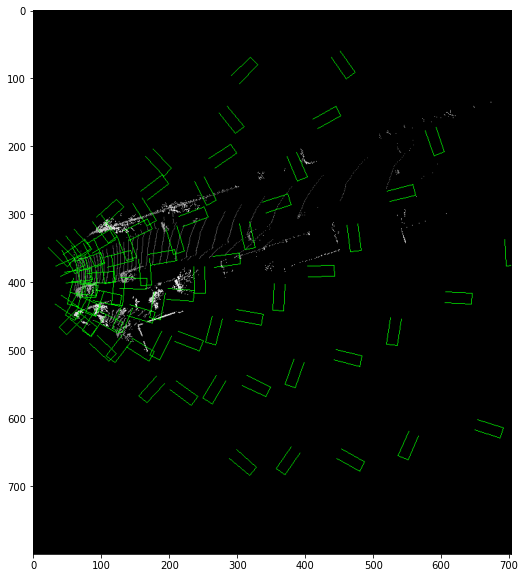

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(bev_map)

In [14]:
anchors_np[0][0]

4.2426405

In [15]:
import torch
a= torch.arange(3,5,step=1)

In [16]:
a

tensor([3, 4])

In [17]:
def create_anchors_3d_sphere_range(feature_size,
                            anchor_range=[0, 70, -0.7853981633974483, +0.7853981633974483],
                            sizes=[1.6, 3.9, 1.56],
                            rotations=[0, np.pi / 2],
                            exp:bool=True,
                            dtype=np.float32):
    """
    create polar grid anchors

    Args:
        feature_size: list [D, H, W](zyx)
        sizes: [N, 3] list of list or array, size of anchors, xyz

        anchor_range: [4], r_min, r_max, phi_min, phi_max
            fix z = -1
        exp: exponential on radius

    Returns:
        anchors: [*feature_size, num_sizes, num_rots, 7] tensor.
    """
    anchor_range = np.array(anchor_range, dtype)
    # r_centers = np.linspace(
    #     anchor_range[0], anchor_range[]
    # )

    if exp:
        r_centers = np.linspace(
            np.log(anchor_range[0]), np.log(anchor_range[1]), 2*feature_size[2]+1, dtype=dtype)[1::2]
        r_centers = np.e ** r_centers
    else:
        r_centers = np.linspace(
            anchor_range[0], anchor_range[1], 2*feature_size[2]+1, dtype=dtype)[1::2]

    phi_centers = np.linspace(
        anchor_range[2], anchor_range[3], feature_size[1], dtype=dtype)

    z_centers = np.linspace( -1 , -1, 1, dtype=dtype)
    # y_centers = np.linspace(
    #     anchor_range[1], anchor_range[4], feature_size[1], dtype=dtype)
    # x_centers = np.linspace(
    #     anchor_range[0], anchor_range[3], feature_size[2], dtype=dtype)


    sizes = np.reshape(np.array(sizes, dtype=dtype), [-1, 3])
    rotations = np.array(rotations, dtype=dtype)
    rets = np.meshgrid(
        r_centers, phi_centers, z_centers, rotations, indexing='ij')

    rets[3] -= rets[1]
    X = rets[0] * np.cos(rets[1])
    Y = rets[0] * np.sin(rets[1])
    rets[0] = X
    rets[1] = Y

    tile_shape = [1] * 5
    tile_shape[-2] = int(sizes.shape[0])
    for i in range(len(rets)):
        rets[i] = np.tile(rets[i][..., np.newaxis, :], tile_shape)
        rets[i] = rets[i][..., np.newaxis]  # for concat
    sizes = np.reshape(sizes, [1, 1, 1, -1, 1, 3])
    tile_size_shape = list(rets[0].shape)
    tile_size_shape[3] = 1
    sizes = np.tile(sizes, tile_size_shape)
    rets.insert(3, sizes)
    ret = np.concatenate(rets, axis=-1)
    res = np.transpose(ret, [2, 1, 0, 3, 4, 5])
    return res      

In [18]:
anc_old = create_anchors_3d_sphere_range([1,64,64],anchor_range=[6, 70.4, np.radians(-45), np.radians(45)])

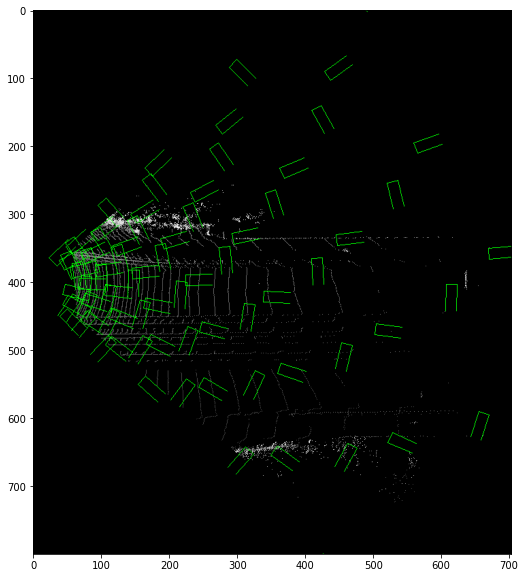

In [19]:
bev_map = kitti_vis(dataset[0]['points'], anc_old.reshape(-1,7)[1::101,:])

import matplotlib.pyplot as plt
plt.figure(figsize = (10,10))
plt.imshow(bev_map)

In [20]:
anc_old

array([[[[[[  4.3250494 ,  -4.3250494 ,  -1.        , ...,
              3.9       ,   1.56      ,   0.7853982 ],
           [  4.3250494 ,  -4.3250494 ,  -1.        , ...,
              3.9       ,   1.56      ,   2.3561945 ]]],


         [[[  4.494701  ,  -4.494701  ,  -1.        , ...,
              3.9       ,   1.56      ,   0.7853982 ],
           [  4.494701  ,  -4.494701  ,  -1.        , ...,
              3.9       ,   1.56      ,   2.3561945 ]]],


         [[[  4.6710067 ,  -4.6710067 ,  -1.        , ...,
              3.9       ,   1.56      ,   0.7853982 ],
           [  4.6710067 ,  -4.6710067 ,  -1.        , ...,
              3.9       ,   1.56      ,   2.3561945 ]]],


         ...,


         [[[ 45.215076  , -45.215076  ,  -1.        , ...,
              3.9       ,   1.56      ,   0.7853982 ],
           [ 45.215076  , -45.215076  ,  -1.        , ...,
              3.9       ,   1.56      ,   2.3561945 ]]],


         [[[ 46.98865   , -46.98865   ,  -1.        , ..

In [21]:
anc_old.shape

(1, 64, 64, 1, 2, 7)

In [22]:
anchors_np.shape

(8192, 7)

In [23]:
anc_old[0][0][0][0][0]

array([ 4.3250494, -4.3250494, -1.       ,  1.6      ,  3.9      ,
        1.56     ,  0.7853982], dtype=float32)

In [24]:

anchors[:][0][0][0][0][0]

tensor([[ 4.2426, -4.2426, -1.0000,  3.9000,  1.6000,  1.5600, -0.7854],
        [ 4.2426, -4.2426, -1.0000,  3.9000,  1.6000,  1.5600,  0.7846]],
       device='cuda:0')

In [25]:
from pcdet.utils import box_utils
box_utils.boxes3d_kitti_lidar_to_fakelidar(anchors[:][0][0][0][0][0].cpu())

array([[ 4.2426405, -4.2426405, -1.78     ,  1.6      ,  3.9      ,
         1.56     , -0.7853982],
       [ 4.2426405, -4.2426405, -1.78     ,  1.6      ,  3.9      ,
         1.56     , -2.3553982]], dtype=float32)

In [26]:
np.log(6)

1.791759469228055

In [27]:
# check rv's bev
rv = dataset[5]['rangeV']

In [28]:
rv.shape

(1, 4, 512, 41, 512)